In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models  # torchvision package contains many types of datasets (including MNIST dataset) and pre-trained models
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

import os
import random
import time
from datetime import timedelta, datetime
from PIL import Image
import cv2  # for video
from google.colab import files, drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# kaggle API
# !pip install -q kaggle
# upload kaggle.json
# files.upload()

# create a kaggle folder
# ! mkdir ~/.kaggle
# copy the kaggle.json to folder created
# ! cp kaggle.json ~/.kaggle/
# permission for the json to act
# ! chmod 600 ~/.kaggle/kaggle.json

# to list all datasets in kaggle
# ! kaggle datasets list
# Van Gogh Paintings
# ! unzip .zip

******************************************************************************

Supporting_Functions

******************************************************************************



In [3]:
# this class includes some general supporting functions for CNN Transfer Learning
class Supporting_Functions:
    def __init__(self, log_filename, content_image_path, style_image_path, device, content_weight, style_weight, learning_rate, steps, storage_limit):
        super().__init__()
        self.log_filename = log_filename
        self.content_image_path = content_image_path
        self.style_image_path = style_image_path
        self.device = device
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.learning_rate = learning_rate
        self.steps = steps
        self.storage_limit = storage_limit

    def enter_log(self, text, header=False):
        file = open(self.log_filename, "a")

        if header:
            log_str = str(datetime.now().strftime("%d/%m/%Y %H:%M:%S")) + "\nContent Image: " + self.content_image_path + "\nStyle Image: " + self.style_image_path \
                      + "\ndevice: " + str(self.device) + ", content_weight: " + str(self.content_weight) + ", style_weight: " + str(self.style_weight) + ", learning_rate: " \
                      + str(self.learning_rate) + ", steps: " + str(self.steps) + ", storage_limit: " + str(self.storage_limit)
            file.write("\n\n" + log_str + "\n\n")

        file.write(text + "\n")
        file.close()

    # 1st dimension: color, 2nd dimension: width, 3rd dimension: height of image and pixels
    def image_convert_to_numpy(self, tensor):
        image = tensor.clone().detach().cpu().numpy()  # clones to tensor and transforms to numpy array. OR tensor.cpu().clone().detach().numpy()
        image = image.squeeze()
        image = image.transpose(1, 2, 0)
        # print(image.shape)                                                                            # (28, 28, 1)
        # denormalize image
        image = image * np.array((0.5,)) + np.array((0.5,))
        image = image.clip(0, 1)
        return image

    def load_image(self, path, max_size=600, shape=None):
        image = Image.open(path).convert('RGB')
        size = max(image.size)

        if size > max_size:
            size = max_size

        if shape is not None:
            size = shape

        # transform image to be compatible with the model
        transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))])

        image = transform(image).unsqueeze(0)  # to add extra dimensionality
        return image

    def create_video(self, images):
      frame_per_sec = 30
      frame_height, frame_width, _ = images[0].shape
      video = cv2.VideoWriter('transformation_video.avi', cv2.VideoWriter_fourcc(*'DIVX'), frame_per_sec, (frame_width, frame_height))

      for i in range(len(images)):
        cur_image = images[i]
        # make current image RGB
        cur_image = cur_image * 255
        cur_image = np.array(cur_image, dtype=np.uint8)
        cur_image = cv2.cvtColor(cur_image, cv2.COLOR_BGR2RGB)
        video.write(cur_image)

      video.release()
      # video is fully written and ready to be saved
      # cv2.destroyAllWindows()
      SF.enter_log('Video created.')

    def plot_images(self, images, nrows=1):
      names = ['Content Image', 'Style Image', 'Target Image']
      fig, axeslist = plt.subplots(ncols=int(len(images)/nrows), nrows=nrows)
      for i in range(len(images)):
        axeslist.ravel()[i].imshow(SF.image_convert_to_numpy(images[i]))
        axeslist.ravel()[i].set_title(names[i])
        axeslist.ravel()[i].set_axis_off()
      plt.tight_layout()
      if len(images) > 2:
        plt.savefig('three_images.jpg', dpi=500, bbox_inches='tight')
      plt.show()

    def save_image(self, image, name):
      # save_image(image, fp=name, normalize=True)
      plt.imshow(SF.image_convert_to_numpy(image))
      plt.axis('off')
      plt.savefig(name, dpi=500, bbox_inches='tight')
      # plt.show()

    def select_image_from_dataset(self, dir_artists, dir_van_gogh):
      choice = input("Van Gogh(V) or All Artists(A):")
      if choice == 'V':
        for i, filename in enumerate(os.listdir(dir_van_gogh)):
          print(filename)
        artist = input("Select type:")
        source_folder = os.path.join(dir_van_gogh, artist)
        image = random.choice(os.listdir(source_folder))        
        while not image.endswith(".jpg"):
          image = random.choice(os.listdir(source_folder))
        print('selected image name:', image)
        return os.path.join(source_folder, image)
      else:
        for i, filename in enumerate(os.listdir(dir_artists)):
          print(filename)
        artist = input("Select artist:")
        source_folder = os.path.join(dir_artists, artist)
        image = random.choice(os.listdir(source_folder))        
        while not image.endswith(".jpg"):
          image = random.choice(os.listdir(source_folder))
        print('selected image name:', image)
        return os.path.join(source_folder, image)
      
      


******************************************************************************

Training Algorithm

******************************************************************************


In [4]:
# HYPERPARAMETERS
# style content ratio: alpha represents content image weight and beta represents style image weight
content_weight = 1
style_weight = 1e6      # (1e1, 1e6)

# learning rate
learning_rate = 0.004

# steps, iterations
steps = 2100
additional_steps = 100

# assign weight to each style layer for representation power (early layers have more style)
style_weights = {'conv1_1': 1.,
                 'conv2_1': .78,
                 'conv3_1': .25,
                 'conv4_1': .22,
                 'conv5_1': .18}

# dictionary that holds the specific layer numbers where features will be extracted. You can play with them.
# Conv1_1, Conv2_1, Conv3_1, Conv4_1, Conv4_2, Conv5_1
layers = {'0': 'conv1_1',    # style extraction
          '5': 'conv2_1',    # style extraction
          '10': 'conv3_1',   # style extraction
          '19': 'conv4_1',   # style extraction
          '21': 'conv4_2',   # content extraction
          '28': 'conv5_1'}   # style extraction

content_layer_ = 'conv4_2'


# AUXILARY PARAMETERS
# step number
storage_limit = 300

# print variables
print_per = 10
show_per = 50


# datasets
dataset_directory_artists = '/content/drive/MyDrive/CS-464 Project/CNN_files/Artists'
dataset_directory_van_gogh = '/content/drive/MyDrive/CS-464 Project/CNN_files/Van_Gogh'

content_image_path = '/content/drive/MyDrive/CS-464 Project/CNN_files/HayleyWilliams.jpg'
# style_image_path = '/content/drive/MyDrive/CS-464 Project/CNN_files/AngelOfLove.jpeg'
log_filename = "/content/drive/MyDrive/CS-464 Project/CNN_files/log_CNN_Style_Transfer.txt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # specifies run device for more optimum runtime

########################################################################################################################

# returns pre-trained VGG19 model
def get_model():
    # VGG 19 pre-trained model
    model = models.vgg19(pretrained=True).features
    SF.enter_log('VGG 19 pre-trained model is created.')

    # freeze parameters
    for param in model.parameters():
        param.requires_grad = False

    # send model to GPU
    model.to(device=device)
    return model


# extracts the features from image using model
def get_features(image, model):
    # dict that will store the extracted features
    features = {}
    # iterate through all layers and store the on es in the layers dict
    for name, layer in model._modules.items():
        # run image through all layers
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
    return features


# Gram Matrix = V(T)*V  T: Transpose
def gram_matrix(tensor):
    # takes 4D image tensor
    # reshape the tensor
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram


def train(model, content_image, style_image, steps):
    # get content and style features
    content_features = get_features(content_image, model)
    style_features = get_features(style_image, model)

    # style features need one more step to be more useful (Gram Matrix)
    # applying Gram Matrix eliminates the remaining content information from style features
    # Gram Matrix = V(T)*V  T: Transpose
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    # define target image
    target_image = content_image.clone().requires_grad_(True).to(device=device)

    # training process images
    height, width, channels = SF.image_convert_to_numpy(target_image).shape
    images = np.empty(shape=(storage_limit, height, width, channels))

    # Adam Optimizer
    optimizer = torch.optim.Adam([target_image], lr=learning_rate)

    # training process
    SF.enter_log('Training begins...')
    iter = 0
    start_training_time = time.time()
    for ii in range(1, steps + 1):
        target_features = get_features(target_image, model)
        # calculate the content loss between content and target images using Mean Squared Error
        content_loss = torch.mean((target_features[content_layer] - content_features[content_layer]) ** 2)

        # calculate style loss iterating through 5 style layers
        style_loss = 0
        for style_layer in style_weights:
            # calculate target gram for cur layer
            target_feature = target_features[style_layer]
            target_gram = gram_matrix(target_feature)
            # get corresponding style gram from the precalculated list
            style_gram = style_grams[style_layer]
            current_style_loss = style_weights[style_layer] * torch.mean((target_gram - style_gram) ** 2)
            # normalize current_style_loss
            _, d, h, w = target_feature.shape
            style_loss += current_style_loss / (d * h * w)

        # optimizer will be used to optimize the parameters of the target image according to content and style losses
        # Style Aim: is to match the target gram matrix to the style gram matrix
        # Content Aim: is to match the target features (filtered image) to the content features
        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()  # reset optimizer
        total_loss.backward()
        optimizer.step()

        # data visualization throughout the training process
        # print period
        if ii % print_per == 0:
            finish_training_time = time.time()
            print_str = 'iteration: ' + str(ii) + ' loss: ' + str(total_loss.item()) + ' time passed: ' + str(timedelta(seconds=finish_training_time - start_training_time))
            print(print_str)
            SF.enter_log(print_str)

        # show image period
        if ii % show_per == 0:
            plt.imshow(SF.image_convert_to_numpy(target_image))
            plt.axis('off')
            plt.show()

        # store mid images period
        if ii % (steps / storage_limit) == 0:
            images[iter] = SF.image_convert_to_numpy(target_image)
            iter += 1

    SF.enter_log('Training completed.')
    return target_image, images



******************************************************************************

Main Function

******************************************************************************

Van Gogh(V) or All Artists(A):V
Works of the young van Gogh
Nuenen
Auvers sur Oise
Arles
Sketches in letters
Villege
Drawings
Face
Saint Remy
Watercolors
Paris
Select type:Villege
selected image name: Peat Boat with Two Figures.jpg


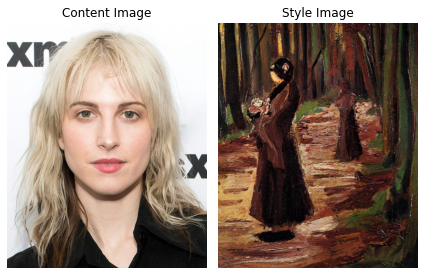

iteration: 10 loss: 26617066.0 time passed: 0:00:04.188579
iteration: 20 loss: 15680523.0 time passed: 0:00:09.225661
iteration: 30 loss: 11324890.0 time passed: 0:00:16.699028
iteration: 40 loss: 9388865.0 time passed: 0:00:21.134711
iteration: 50 loss: 8228071.0 time passed: 0:00:29.189941


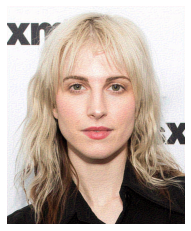

iteration: 60 loss: 7447457.5 time passed: 0:00:33.541082
iteration: 70 loss: 6871873.5 time passed: 0:00:39.114212
iteration: 80 loss: 6424625.0 time passed: 0:00:45.978478
iteration: 90 loss: 6062002.0 time passed: 0:00:50.970034
iteration: 100 loss: 5758375.0 time passed: 0:00:58.379582


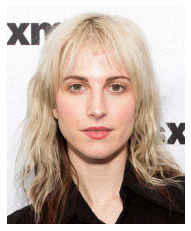

iteration: 110 loss: 5498164.5 time passed: 0:01:02.942729
iteration: 120 loss: 5271580.0 time passed: 0:01:10.903159
iteration: 130 loss: 5071934.0 time passed: 0:01:15.071272
iteration: 140 loss: 4894319.0 time passed: 0:01:20.645519
iteration: 150 loss: 4735203.5 time passed: 0:01:27.478159


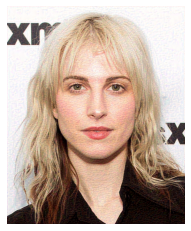

iteration: 160 loss: 4591718.0 time passed: 0:01:32.614385
iteration: 170 loss: 4461822.0 time passed: 0:01:40.045716
iteration: 180 loss: 4343721.0 time passed: 0:01:44.433919
iteration: 190 loss: 4236014.5 time passed: 0:01:52.386439
iteration: 200 loss: 4137424.75 time passed: 0:01:56.570837


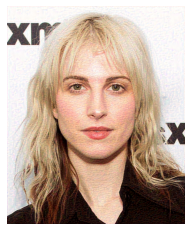

iteration: 210 loss: 4046898.25 time passed: 0:02:02.281820
iteration: 220 loss: 3963458.0 time passed: 0:02:09.069084
iteration: 230 loss: 3886325.0 time passed: 0:02:14.057504
iteration: 240 loss: 3814788.25 time passed: 0:02:21.467376
iteration: 250 loss: 3748197.0 time passed: 0:02:25.874772


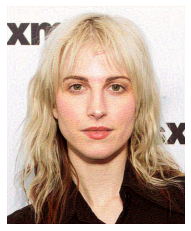

iteration: 260 loss: 3686019.75 time passed: 0:02:34.012001
iteration: 270 loss: 3627776.25 time passed: 0:02:38.160354
iteration: 280 loss: 3573061.5 time passed: 0:02:43.697707
iteration: 290 loss: 3521498.25 time passed: 0:02:50.488758
iteration: 300 loss: 3472774.0 time passed: 0:02:55.480850


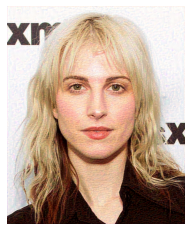

iteration: 310 loss: 3426612.5 time passed: 0:03:03.058744
iteration: 320 loss: 3382760.5 time passed: 0:03:07.454754
iteration: 330 loss: 3340994.75 time passed: 0:03:15.434403
iteration: 340 loss: 3301104.75 time passed: 0:03:19.587394
iteration: 350 loss: 3262924.5 time passed: 0:03:25.123035


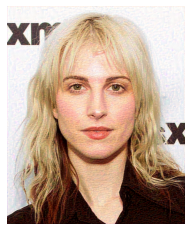

iteration: 360 loss: 3226301.75 time passed: 0:03:32.097460
iteration: 370 loss: 3191125.75 time passed: 0:03:37.086502
iteration: 380 loss: 3157278.5 time passed: 0:03:44.476288
iteration: 390 loss: 3124668.5 time passed: 0:03:48.884082
iteration: 400 loss: 3093194.0 time passed: 0:03:56.866895


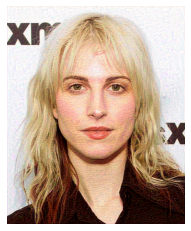

iteration: 410 loss: 3062781.25 time passed: 0:04:01.198933
iteration: 420 loss: 3033369.5 time passed: 0:04:06.765592
iteration: 430 loss: 3004877.5 time passed: 0:04:13.604858
iteration: 440 loss: 2977245.75 time passed: 0:04:18.571049
iteration: 450 loss: 2950432.75 time passed: 0:04:25.971363


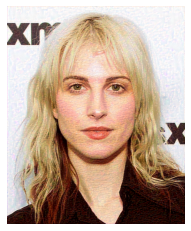

iteration: 460 loss: 2924391.75 time passed: 0:04:30.509044
iteration: 470 loss: 2899088.75 time passed: 0:04:38.472027
iteration: 480 loss: 2874479.25 time passed: 0:04:42.649363
iteration: 490 loss: 2850524.75 time passed: 0:04:48.204194
iteration: 500 loss: 2827199.5 time passed: 0:04:55.031737


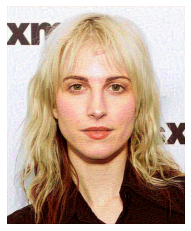

iteration: 510 loss: 2804470.0 time passed: 0:05:00.158115
iteration: 520 loss: 2782308.75 time passed: 0:05:07.602234
iteration: 530 loss: 2760688.5 time passed: 0:05:11.978869
iteration: 540 loss: 2739585.0 time passed: 0:05:19.940335
iteration: 550 loss: 2718977.75 time passed: 0:05:24.112071


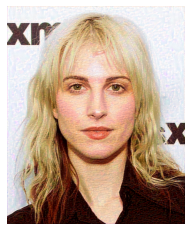

iteration: 560 loss: 2698840.5 time passed: 0:05:29.901361
iteration: 570 loss: 2679159.0 time passed: 0:05:36.695648
iteration: 580 loss: 2659912.75 time passed: 0:05:41.679861
iteration: 590 loss: 2641076.5 time passed: 0:05:49.088952
iteration: 600 loss: 2622638.0 time passed: 0:05:53.477862


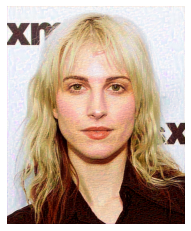

iteration: 610 loss: 2604577.25 time passed: 0:06:01.602683
iteration: 620 loss: 2586880.75 time passed: 0:06:05.762246
iteration: 630 loss: 2569538.0 time passed: 0:06:11.303857
iteration: 640 loss: 2552535.0 time passed: 0:06:18.107357
iteration: 650 loss: 2535851.75 time passed: 0:06:23.101642


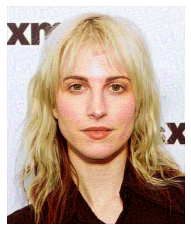

iteration: 660 loss: 2519472.25 time passed: 0:06:30.675460
iteration: 670 loss: 2503389.0 time passed: 0:06:35.062117
iteration: 680 loss: 2487586.5 time passed: 0:06:43.051039
iteration: 690 loss: 2472054.75 time passed: 0:06:47.227931
iteration: 700 loss: 2456785.0 time passed: 0:06:52.772641


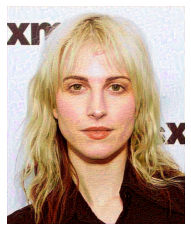

iteration: 710 loss: 2441770.5 time passed: 0:06:59.740658
iteration: 720 loss: 2426999.0 time passed: 0:07:04.736761
iteration: 730 loss: 2412457.0 time passed: 0:07:12.132720
iteration: 740 loss: 2398135.25 time passed: 0:07:16.526858
iteration: 750 loss: 2384028.75 time passed: 0:07:24.526523


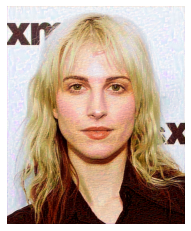

iteration: 760 loss: 2370127.5 time passed: 0:07:28.865624
iteration: 770 loss: 2356424.75 time passed: 0:07:34.435623
iteration: 780 loss: 2342911.25 time passed: 0:07:41.264798
iteration: 790 loss: 2329582.25 time passed: 0:07:46.247818
iteration: 800 loss: 2316432.25 time passed: 0:07:53.643023


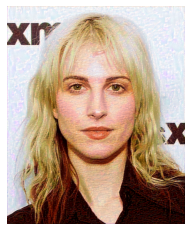

iteration: 810 loss: 2303454.75 time passed: 0:07:58.208461
iteration: 820 loss: 2290641.0 time passed: 0:08:06.192230
iteration: 830 loss: 2277985.25 time passed: 0:08:10.347398
iteration: 840 loss: 2265480.0 time passed: 0:08:15.924854
iteration: 850 loss: 2253118.5 time passed: 0:08:22.837790


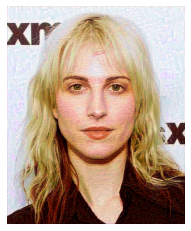

iteration: 860 loss: 2240895.5 time passed: 0:08:27.958194
iteration: 870 loss: 2228811.5 time passed: 0:08:35.407524
iteration: 880 loss: 2216859.0 time passed: 0:08:39.792342
iteration: 890 loss: 2205036.0 time passed: 0:08:47.760067
iteration: 900 loss: 2193340.0 time passed: 0:08:51.937218


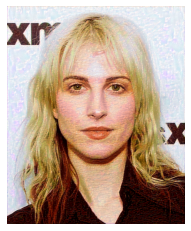

iteration: 910 loss: 2181766.0 time passed: 0:08:57.646771
iteration: 920 loss: 2170314.0 time passed: 0:09:04.448174


In [ ]:
SF = Supporting_Functions(log_filename, content_image_path, '/from dataset', device, content_weight, style_weight, learning_rate, steps, storage_limit)

# get content and style images
content_image = SF.load_image(content_image_path).to(device=device)
style_image_path = SF.select_image_from_dataset(dataset_directory_artists, dataset_directory_van_gogh)
style_image = SF.load_image(style_image_path, shape=content_image.shape[-2:]).to(device=device)
SF.enter_log('Content and Style images are retrieved.', header=True)

# get VGG19 pre-trained model
model = get_model()

# plot content and style images
SF.plot_images([content_image, style_image])

# train target image
target_image, images = train(model, content_image, style_image, steps)

# plot content, style, and target images
SF.plot_images([content_image, style_image, target_image])

# save target image
# SF.save_image(target_image, 'target1.jpg')

# create video
# SF.create_video(images)

******************************************************************************

Second Main Function

******************************************************************************

In [ ]:
def train2(model, content_image, style_image, steps_, target_image):
    # get content and style features
    content_features = get_features(content_image, model)
    style_features = get_features(style_image, model)

    # style features need one more step to be more useful (Gram Matrix)
    # applying Gram Matrix eliminates the remaining content information from style features
    # Gram Matrix = V(T)*V  T: Transpose
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


    # training process images
    height, width, channels = SF.image_convert_to_numpy(target_image).shape
    images = np.empty(shape=(storage_limit, height, width, channels))

    # Adam Optimizer
    optimizer = torch.optim.Adam([target_image], lr=learning_rate)

    # training process
    iter = 0
    start_training_time = time.time()
    for ii in range(1, steps_ + 1):
        target_features = get_features(target_image, model)
        # calculate the content loss between content and target images using Mean Squared Error
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

        # calculate style loss iterating through 5 style layers
        style_loss = 0
        for style_layer in style_weights:
            # calculate target gram for cur layer
            target_feature = target_features[style_layer]
            target_gram = gram_matrix(target_feature)
            # get corresponding style gram from the precalculated list
            style_gram = style_grams[style_layer]
            current_style_loss = style_weights[style_layer] * torch.mean((target_gram - style_gram) ** 2)
            # normalize current_style_loss
            _, d, h, w = target_feature.shape
            style_loss += current_style_loss / (d * h * w)

        # optimizer will be used to optimize the parameters of the target image according to content and style losses
        # Style Aim: is to match the target gram matrix to the style gram matrix
        # Content Aim: is to match the target features (filtered image) to the content features
        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()  # reset optimizer
        total_loss.backward()
        optimizer.step()

        # data visualization throughout the training process
        # print period
        if ii % print_per == 0:
            finish_training_time = time.time()
            print_str = 'iteration: ' + str(ii + steps) + ' loss: ' + str(total_loss.item() / (height * width)) + ' time passed: ' + str(timedelta(seconds=finish_training_time - start_training_time))
            print(print_str)
            SF.enter_log(print_str)

        # show image period
        if ii % show_per == 0:
            plt.imshow(SF.image_convert_to_numpy(target_image))
            plt.axis('off')
            plt.show()

    SF.enter_log('Training completed.')
    return target_image


In [ ]:
# plot content and style images
SF.plot_images([content_image, style_image, target_image])

# train target image
target_image = train2(model, content_image, style_image, additional_steps, target_image)

In [ ]:
# plot content, style, and target images
SF.plot_images([content_image, style_image, target_image])

# save target image
SF.save_image(target_image, 'target_image.jpg')

# create video
SF.create_video(images)